Doing feature selection after getting optimized hyperparameters, else this would cause overfitting the feature space to a single configuration.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# Load the data
print("Loading data...")
df = pd.read_csv(r"C:\Users\sk282\Downloads\archive\UCI_Credit_Card.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Loading data...
Dataset shape: (30000, 25)

Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']


In [2]:
# STEP 1: DATA PREPROCESSING
print("\n" + "="*50)
print("STEP 1: DATA PREPROCESSING")
print("="*50)

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Separate features and target
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

# Remove ID column if exists
if 'ID' in X.columns:
    X = X.drop('ID', axis=1)

print(f"\nTarget distribution:\n{y.value_counts()}")
print(f"\nClass imbalance ratio: {y.value_counts()[0]/y.value_counts()[1]:.2f}:1")

# Handle any outliers using IQR method
def remove_outliers_iqr(df, columns, multiplier=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        df_clean[col] = df_clean[col].clip(lower, upper)
    return df_clean

# Apply outlier treatment to numerical columns
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = remove_outliers_iqr(X, numerical_cols)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# HANDLE CLASS IMBALANCE using SMOTE
print("\n" + "="*50)
print("HANDLING CLASS IMBALANCE")
print("="*50)

print(f"\nBefore SMOTE - Class distribution:")
print(f"Class 0: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"Class 1: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.2f}%)")

# Apply SMOTE with RandomUnderSampler for balanced approach
smote = SMOTE(sampling_strategy=0.8, random_state=42)  # Oversample minority to 80% of majority
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # Then balance

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

print(f"\nAfter SMOTE + Undersampling - Class distribution:")
print(f"Class 0: {sum(y_train_resampled == 0)} ({sum(y_train_resampled == 0)/len(y_train_resampled)*100:.2f}%)")
print(f"Class 1: {sum(y_train_resampled == 1)} ({sum(y_train_resampled == 1)/len(y_train_resampled)*100:.2f}%)")

# Standardize features AFTER resampling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Update y_train to use resampled version
y_train = y_train_resampled

print(f"\nTraining set size: {X_train_scaled.shape}")
print(f"Test set size: {X_test_scaled.shape}")


STEP 1: DATA PREPROCESSING

Missing values:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

Target distribution:
default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

Class imbalance ratio: 3.52:1

HANDLING CLAS

In [3]:
# STEP 2: FILTER METHOD - Feature Selection
print("\n" + "="*50)
print("STEP 2: FILTER METHOD - FEATURE SELECTION")
print("="*50)

# Method 1: ANOVA F-test
selector_anova = SelectKBest(score_func=f_classif, k=15)
selector_anova.fit(X_train_scaled, y_train)
anova_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'ANOVA_Score': selector_anova.scores_
}).sort_values('ANOVA_Score', ascending=False)

print("\nTop 15 features by ANOVA F-test:")
print(anova_scores.head(15))

# Method 2: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=15)
selector_mi.fit(X_train_scaled, y_train)
mi_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)

print("\nTop 15 features by Mutual Information:")
print(mi_scores.head(15))

# Combine both methods - select features that appear in top 15 of either
top_features_anova = set(anova_scores.head(15)['Feature'].tolist())
top_features_mi = set(mi_scores.head(15)['Feature'].tolist())
selected_features_filter = list(top_features_anova.union(top_features_mi))

print(f"\nTotal features selected by filter methods: {len(selected_features_filter)}")
print(f"Features: {selected_features_filter}")

X_train_filtered = X_train_scaled[selected_features_filter]
X_test_filtered = X_test_scaled[selected_features_filter]


STEP 2: FILTER METHOD - FEATURE SELECTION

Top 15 features by ANOVA F-test:
      Feature  ANOVA_Score
5       PAY_0  4272.302990
6       PAY_2  2517.461435
7       PAY_3  2022.993682
8       PAY_4  1656.075216
9       PAY_5  1333.453175
0   LIMIT_BAL  1267.221367
1         SEX  1255.356951
17   PAY_AMT1  1153.264974
10      PAY_6  1094.933942
18   PAY_AMT2  1020.927547
3    MARRIAGE   976.379112
19   PAY_AMT3   924.052652
22   PAY_AMT6   803.149200
21   PAY_AMT5   712.698916
20   PAY_AMT4   678.587741

Top 15 features by Mutual Information:
      Feature  MI_Score
4         AGE  0.285316
5       PAY_0  0.236424
6       PAY_2  0.163087
2   EDUCATION  0.154551
7       PAY_3  0.140758
8       PAY_4  0.137940
9       PAY_5  0.125918
10      PAY_6  0.121540
0   LIMIT_BAL  0.074803
22   PAY_AMT6  0.069231
19   PAY_AMT3  0.066572
18   PAY_AMT2  0.065884
17   PAY_AMT1  0.064402
21   PAY_AMT5  0.063964
20   PAY_AMT4  0.059171

Total features selected by filter methods: 17
Features: ['PAY_4', 

In [4]:
# STEP 3: PARTICLE SWARM OPTIMIZATION for XGBoost
print("\n" + "="*50)
print("STEP 3: PARTICLE SWARM OPTIMIZATION")
print("="*50)

class Particle:
    def __init__(self, bounds):
        self.position = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
        self.velocity = np.random.uniform(-1, 1, len(bounds))
        self.best_position = self.position.copy()
        self.best_score = -np.inf
        
class PSO:
    def __init__(self, n_particles, bounds, n_iterations, w=0.7, c1=1.5, c2=1.5):
        self.n_particles = n_particles
        self.bounds = bounds
        self.n_iterations = n_iterations
        self.w = w  # inertia weight
        self.c1 = c1  # cognitive parameter
        self.c2 = c2  # social parameter
        self.particles = [Particle(bounds) for _ in range(n_particles)]
        self.global_best_position = None
        self.global_best_score = -np.inf
        self.history = []
        
    def optimize(self, objective_function):
        for iteration in range(self.n_iterations):
            for particle in self.particles:
                # Evaluate fitness
                score = objective_function(particle.position)
                
                # Update personal best
                if score > particle.best_score:
                    particle.best_score = score
                    particle.best_position = particle.position.copy()
                
                # Update global best
                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = particle.position.copy()
            
            # Update velocities and positions
            for particle in self.particles:
                r1, r2 = np.random.random(len(self.bounds)), np.random.random(len(self.bounds))
                cognitive = self.c1 * r1 * (particle.best_position - particle.position)
                social = self.c2 * r2 * (self.global_best_position - particle.position)
                particle.velocity = self.w * particle.velocity + cognitive + social
                particle.position = particle.position + particle.velocity
                
                # Apply bounds
                for i, (low, high) in enumerate(self.bounds):
                    particle.position[i] = np.clip(particle.position[i], low, high)
            
            self.history.append(self.global_best_score)
            print(f"Iteration {iteration+1}/{self.n_iterations}, Best Score: {self.global_best_score:.6f}")
        
        return self.global_best_position, self.global_best_score

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Define objective function for XGBoost
def objective_xgb(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    learning_rate = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    min_child_weight = int(params[5])
    gamma = params[6]
    reg_alpha = params[7]
    reg_lambda = params[8]
    
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,  # Handle class imbalance
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Use cross-validation for robust evaluation
    scores = cross_val_score(model, X_train_filtered, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return scores.mean()

# Define parameter bounds for PSO (XGBoost specific)
bounds = [
    (50, 300),      # n_estimators
    (3, 15),        # max_depth
    (0.01, 0.3),    # learning_rate
    (0.6, 1.0),     # subsample
    (0.6, 1.0),     # colsample_bytree
    (1, 10),        # min_child_weight
    (0.0, 0.5),     # gamma
    (0.0, 1.0),     # reg_alpha (L1 regularization)
    (0.0, 1.0)      # reg_lambda (L2 regularization)
]

print("\nRunning PSO optimization for XGBoost...")
pso = PSO(n_particles=10, bounds=bounds, n_iterations=15)
best_params, best_score = pso.optimize(objective_xgb)




STEP 3: PARTICLE SWARM OPTIMIZATION

Running PSO optimization for XGBoost...
Iteration 1/15, Best Score: 0.794242
Iteration 2/15, Best Score: 0.794242
Iteration 3/15, Best Score: 0.795813
Iteration 4/15, Best Score: 0.800428
Iteration 5/15, Best Score: 0.801063
Iteration 6/15, Best Score: 0.801866
Iteration 7/15, Best Score: 0.803070
Iteration 8/15, Best Score: 0.803070
Iteration 9/15, Best Score: 0.803471
Iteration 10/15, Best Score: 0.803772
Iteration 11/15, Best Score: 0.804374
Iteration 12/15, Best Score: 0.804374
Iteration 13/15, Best Score: 0.804374
Iteration 14/15, Best Score: 0.804374
Iteration 15/15, Best Score: 0.804374


In [5]:
print("PSO OPTIMIZATION RESULTS")
print('='*50)
print(f"Best CV Accuracy: {best_score:.6f}")
print(f"\nBest Parameters:")
print(f"  n_estimators: {int(best_params[0])}")
print(f"  max_depth: {int(best_params[1])}")
print(f"  learning_rate: {best_params[2]:.4f}")
print(f"  subsample: {best_params[3]:.4f}")
print(f"  colsample_bytree: {best_params[4]:.4f}")
print(f"  min_child_weight: {int(best_params[5])}")
print(f"  gamma: {best_params[6]:.4f}")
print(f"  reg_alpha: {best_params[7]:.4f}")
print(f"  reg_lambda: {best_params[8]:.4f}")

PSO OPTIMIZATION RESULTS
Best CV Accuracy: 0.804374

Best Parameters:
  n_estimators: 300
  max_depth: 15
  learning_rate: 0.0100
  subsample: 0.6380
  colsample_bytree: 1.0000
  min_child_weight: 1
  gamma: 0.0000
  reg_alpha: 0.0000
  reg_lambda: 0.0000


In [6]:
# Train model with best parameters
best_model = xgb.XGBClassifier(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    learning_rate=best_params[2],
    subsample=best_params[3],
    colsample_bytree=best_params[4],
    min_child_weight=int(best_params[5]),
    gamma=best_params[6],
    reg_alpha=best_params[7],
    reg_lambda=best_params[8],
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)

best_model.fit(X_train_filtered, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(1.0), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(0.0), grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=np.float64(0.01),
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [7]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_features_filter,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance from XGBoost:")
print(feature_importance)

# Select top features based on importance (keep features contributing to 95% cumulative importance)
feature_importance['Cumulative_Importance'] = feature_importance['Importance'].cumsum() / feature_importance['Importance'].sum()
selected_features_wrapper = feature_importance[feature_importance['Cumulative_Importance'] <= 0.95]['Feature'].tolist()

# Ensure at least 10 features are selected
if len(selected_features_wrapper) < 10:
    selected_features_wrapper = feature_importance.head(10)['Feature'].tolist()

print(f"\nFeatures selected by wrapper method: {len(selected_features_wrapper)}")
print(f"Features: {selected_features_wrapper}")

X_train_final = X_train_filtered[selected_features_wrapper]
X_test_final = X_test_filtered[selected_features_wrapper]


Feature Importance from XGBoost:
      Feature  Importance
5       PAY_0    0.450042
11      PAY_2    0.092566
4       PAY_3    0.056305
7   EDUCATION    0.055105
10      PAY_5    0.037065
0       PAY_4    0.035227
16      PAY_6    0.033046
3    MARRIAGE    0.032741
8         SEX    0.029905
14   PAY_AMT1    0.023843
13   PAY_AMT2    0.023637
12   PAY_AMT3    0.022929
15   PAY_AMT6    0.022126
6   LIMIT_BAL    0.021958
9    PAY_AMT4    0.021652
1    PAY_AMT5    0.021376
2         AGE    0.020475

Features selected by wrapper method: 14
Features: ['PAY_0', 'PAY_2', 'PAY_3', 'EDUCATION', 'PAY_5', 'PAY_4', 'PAY_6', 'MARRIAGE', 'SEX', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT6', 'LIMIT_BAL']


In [8]:
# STEP 5: FINAL MODEL TRAINING AND EVALUATION
print("\n" + "="*50)
print("STEP 5: FINAL MODEL TRAINING AND EVALUATION")
print("="*50)

# Train final model with selected features
final_model = xgb.XGBClassifier(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    learning_rate=best_params[2],
    subsample=best_params[3],
    colsample_bytree=best_params[4],
    min_child_weight=int(best_params[5]),
    gamma=best_params[6],
    reg_alpha=best_params[7],
    reg_lambda=best_params[8],
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)

print("\nTraining final model...")
final_model.fit(X_train_final, y_train)

# Predictions
y_pred_train = final_model.predict(X_train_final)
y_pred_test = final_model.predict(X_test_final)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTraining Accuracy: {train_accuracy:.6f}")
print(f"Test Accuracy: {test_accuracy:.6f}")


STEP 5: FINAL MODEL TRAINING AND EVALUATION

Training final model...

Training Accuracy: 0.947833
Test Accuracy: 0.802167


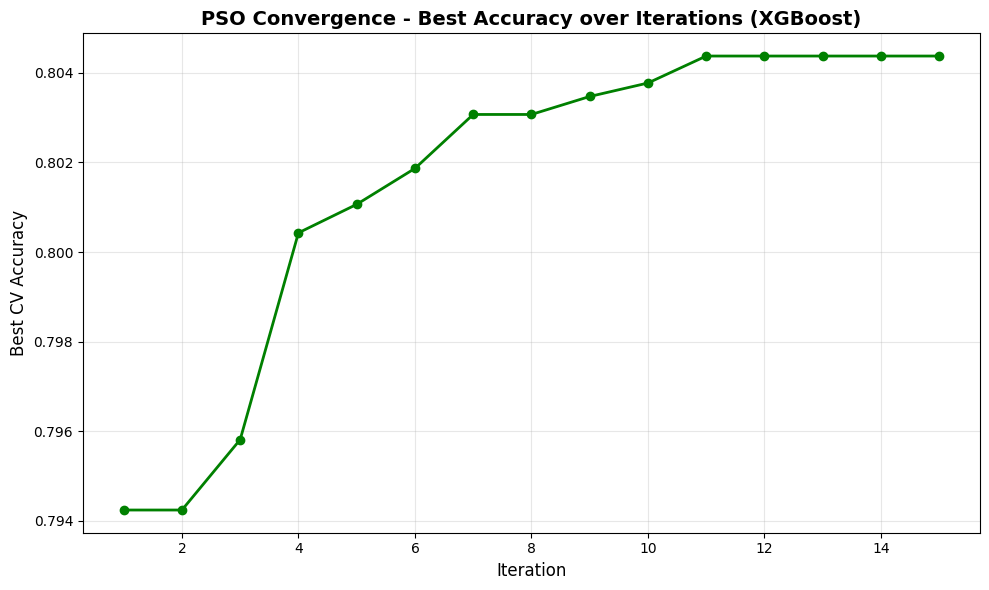

In [9]:
# Plot PSO convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pso.history)+1), pso.history, marker='o', linewidth=2, markersize=6, color='green')
plt.title('PSO Convergence - Best Accuracy over Iterations (XGBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best CV Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


CLASSIFICATION REPORT

                 precision    recall  f1-score   support

No Default (0)       0.85      0.90      0.88      4673
   Default (1)       0.57      0.45      0.50      1327

      accuracy                           0.80      6000
     macro avg       0.71      0.68      0.69      6000
  weighted avg       0.79      0.80      0.79      6000


Additional Metrics:
  ROC-AUC Score: 0.753255
  F1 Score: 0.500631
  Precision: 0.566667
  Recall: 0.448380


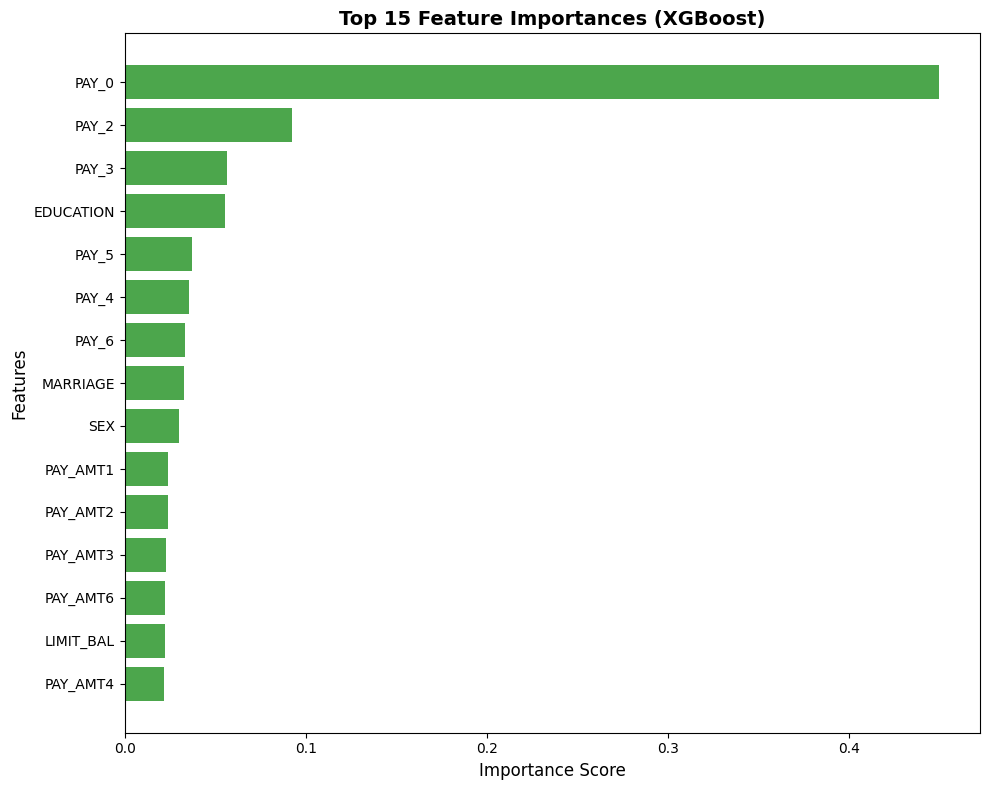

In [10]:
# CLASSIFICATION REPORT
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)

print("\n", classification_report(y_test, y_pred_test, 
                                  target_names=['No Default (0)', 'Default (1)']))

# Additional metrics
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

y_pred_proba = final_model.predict_proba(X_test_final)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print("\nAdditional Metrics:")
print(f"  ROC-AUC Score: {roc_auc:.6f}")
print(f"  F1 Score: {f1:.6f}")
print(f"  Precision: {precision:.6f}")
print(f"  Recall: {recall:.6f}")

# Plot feature importance
plt.figure(figsize=(10, 8))
feature_imp_sorted = feature_importance.head(15).sort_values('Importance')
plt.barh(range(len(feature_imp_sorted)), feature_imp_sorted['Importance'], color='green', alpha=0.7)
plt.yticks(range(len(feature_imp_sorted)), feature_imp_sorted['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


CONFUSION MATRIX

Confusion Matrix:
[[4218  455]
 [ 732  595]]


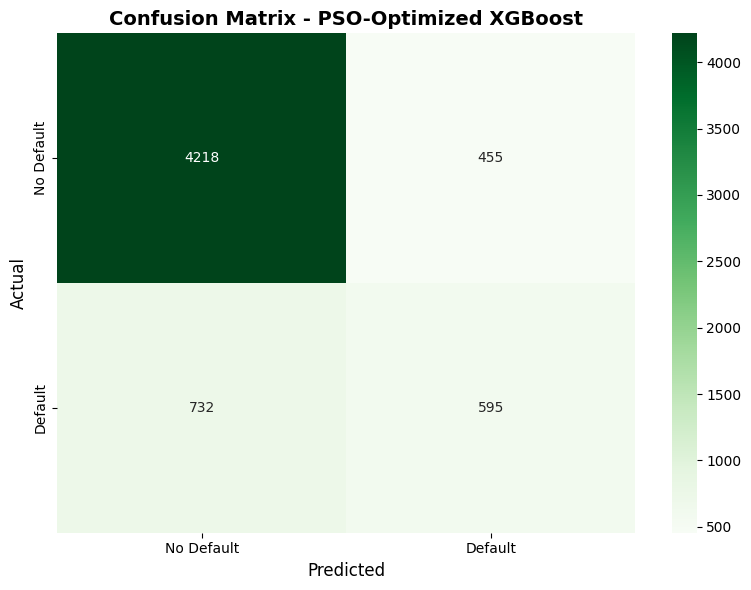

In [11]:
# CONFUSION MATRIX
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

cm = confusion_matrix(y_test, y_pred_test)
print(f"\nConfusion Matrix:\n{cm}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix - PSO-Optimized XGBoost', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()
